In [1]:
import pandas as pd
import time
from tqdm import tqdm
import os
import re
import string
from collections import Counter
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
from rouge_score import rouge_scorer
from bert_score import score
from nltk.translate import meteor_score
from transformers import pipeline, BartTokenizer, BartForConditionalGeneration
import matplotlib.pyplot as plt
from openai import OpenAI
from bert_score import BERTScorer
import matplotlib.pyplot as plt

file_name = "exp_result_Mixtral-8x7B-Instruct-v0.1.csv"
foler_path = "Paper Experiment Results/New_filtered/mt"

output_file_name = file_name.replace(".csv", "_evaluated.csv")
input_path = os.path.join(foler_path, file_name)
output_path = os.path.join(foler_path, output_file_name)
_data = pd.read_csv(input_path)
eval_model = "gpt-3.5-turbo-0125"
api_key = os.getenv("OPENAI_API_KEY")
client = OpenAI(api_key=api_key)
temperature = 0

/home/lujun/anaconda3/envs/causalLLM/lib/python3.9/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
`AnnotionFormat` is deprecated and will be removed in v4.38. Please use `transformers.image_utils.AnnotationFormat` instead.
2024-06-09 15:20:09.464699: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/lujun/anaconda3/envs/causalLLM/lib/python3.9/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [10]:
def extract_final_response(response, prompt):
    return response[len(prompt) :]


def match_prompt_column(model):
    if "Llama-2" in model:
        return "llama2_chat_initial_prompt"
    elif "Mixtral" in model or "Mistral" in model:
        return "mixtral_instruct_initial_prompt"
    elif "Llama-3" in model:
        return "llama3_chat_initial_prompt"
    else:
        print("The model name didn't match anything, please check!!!!")
        return None


def extract_pure_response(row):
    model = row["model"]
    prompt_column = match_prompt_column(model)
    response = row["generated_response"]
    prompt = row[prompt_column]
    return extract_final_response(response=response, prompt=prompt)


def process_string(input_string):
    processed_string = input_string.strip("[]").replace("\\", "")
    questions = processed_string.split("\n")
    questions = [q.strip("'") for q in questions]
    return questions


_data["pure_response"] = _data.apply(extract_pure_response, axis=1)

In [11]:
from sacrebleu.metrics import BLEU

bleu = BLEU(tokenize="flores101", effective_order=True)
sys = _data.pure_response.to_list()
refs = _data.sentence_target.to_list()

result = bleu.sentence_score(hypothesis=sys[0], references=[refs[0]]).score


def calculate_sp_bleu(row):
    reference = row["sentence_target"]
    generated_answer = row["pure_response"]
    score = bleu.sentence_score(
        hypothesis=generated_answer, references=[reference]
    ).score
    return score


_data["spbleu"] = _data.apply(calculate_sp_bleu, axis=1)

In [12]:
_data.to_csv(output_path, index=False)

# Draw Figure Together

In [1]:
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt

current_time = datetime.datetime.now()
current_time_str = current_time.strftime("%Y%m%d%H%M%S")
model_weight_sizes = {
    "Llama-2-13b-chat-hf": 13,
    "Mistral-7B-Instruct-v0.2": 7,
    "Llama-2-70b-chat-hf": 70,
    "Meta-Llama-3-8B-Instruct": 8,
    "Llama-2-7b-chat-hf": 7,
    "Mixtral-8x7B-Instruct-v0.1": 56,
}

folder_path = "Paper Experiment Results/New_filtered/mt"
output_photo_name = f"MT_{current_time_str}.svg"
output_photo_path = os.path.join(folder_path, output_photo_name)
all_dfs = []
for filename in os.listdir(folder_path):
    if filename.endswith(".csv") and "evaluated" in filename:
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path)
        model_name = filename.split("_")[2]
        df["model_name"] = model_name
        df["weight_size"] = model_weight_sizes.get(model_name, None)
        all_dfs.append(df)

df = pd.concat(all_dfs, ignore_index=True)
df = df[~df["spbleu"].isna()]

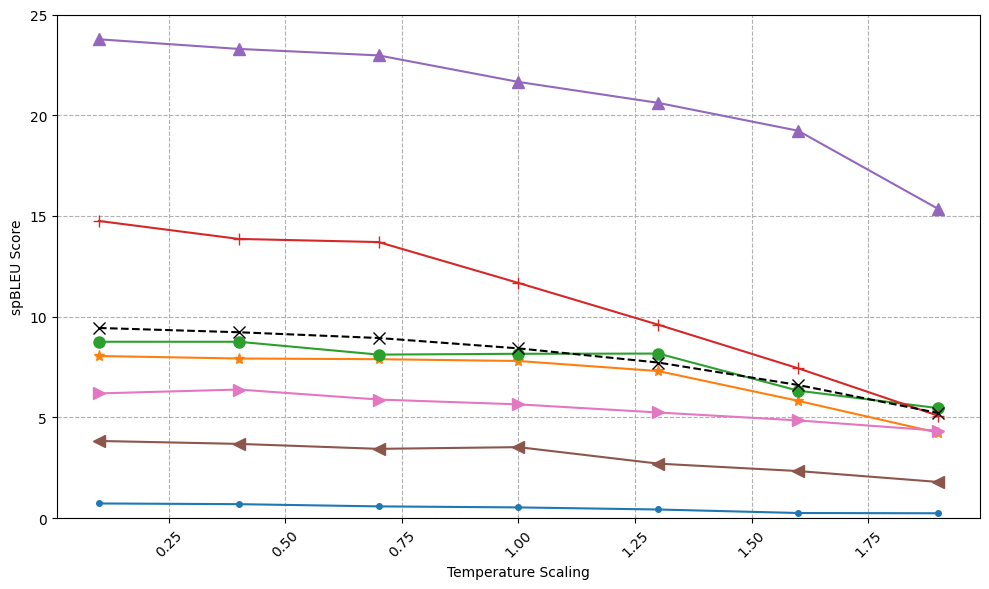

In [2]:
grouped_data = df.groupby(["model", "Temperature"])["spbleu"].mean()

models = [
    "Llama-2-7b-chat-hf",
    "Llama-2-13b-chat-hf",
    "Llama-2-70b-chat-hf",
    "Meta-Llama-3-8B-Instruct",
    "Meta-Llama-3-70B-Instruct",
    "Mistral-7B-Instruct-v0.2",
    "Mixtral-8x7B-Instruct-v0.1",
]

markers = [
    ".",
    "*",
    "o",
    "+",
    "^",
    "<",
    ">",
    "8",
    "s",
    "p",
    ",",
    "v",
    "D",
    "d",
    "x",
    "|",
    "_",
]

plt.figure(figsize=(10, 6))
for i, model in enumerate(models):
    model_data = grouped_data[model]
    marker = markers[i % len(markers)]  # Select marker cyclically from the list
    plt.plot(
        model_data.index.get_level_values("Temperature"),
        model_data,
        marker=marker,
        markersize=8,
        label=model,
    )

grouped_data_temperature = df.groupby(["Temperature"])["spbleu"].mean()
plt.plot(
    grouped_data_temperature.index,
    grouped_data_temperature,
    linestyle="--",
    marker="x",
    markersize=8,
    color="black",
    label="Average Score Among All Models",
)

plt.ylim(0, 25)

plt.xlabel("Temperature Scaling")
plt.ylabel("spBLEU Score")
# plt.title("Machine Translation\nMean spBLEU Score with Temperature Across Models")
plt.grid(
    linestyle="--",
)
plt.xticks(rotation=45)
plt.tight_layout()

# plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.savefig(output_photo_path, format="svg", bbox_inches="tight")
# plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.show()

# Causal Estimation

In [3]:
import pandas as pd
import os
import datetime
import numpy as np
import warnings
from dowhy import CausalModel
from sklearn.linear_model import LinearRegression

model_weight_sizes = {
    "Llama-2-13b-chat-hf": 13,
    "Mistral-7B-Instruct-v0.2": 7,
    "Llama-2-70b-chat-hf": 70,
    "Meta-Llama-3-8B-Instruct": 8,
    "Llama-2-7b-chat-hf": 7,
    "Mixtral-8x7B-Instruct-v0.1": 56,
}

model_map = {
    "Llama-2-7b-chat-hf": 0,
    "Llama-2-13b-chat-hf": 1,
    "Llama-2-70b-chat-hf": 2,
    "Meta-Llama-3-8B-Instruct": 3,
    "Meta-Llama-3-70B-Instruct": 4,
    "Mistral-7B-Instruct-v0.2": 5,
    "Mixtral-8x7B-Instruct-v0.1": 6,
}

marker_map = {
    "Llama-2-7b-chat-hf": ".",
    "Llama-2-13b-chat-hf": "*",
    "Llama-2-70b-chat-hf": "o",
    "Meta-Llama-3-8B-Instruct": "+",
    "Meta-Llama-3-70B-Instruct": "^",
    "Mistral-7B-Instruct-v0.2": "<",
    "Mixtral-8x7B-Instruct-v0.1": ">",
}

color_map = {
    "Llama-2-7b-chat-hf": "C0",
    "Llama-2-13b-chat-hf": "C1",
    "Llama-2-70b-chat-hf": "C2",
    "Meta-Llama-3-8B-Instruct": "C3",
    "Meta-Llama-3-70B-Instruct": "C4",
    "Mistral-7B-Instruct-v0.2": "C5",
    "Mixtral-8x7B-Instruct-v0.1": "C6",
}
# Data Preprocessing
warnings.filterwarnings("ignore")
current_time = datetime.datetime.now()
current_time_str = current_time.strftime("%Y%m%d%H%M%S")

folder_path = "Paper Experiment Results/New_filtered/mt"
output_photo_name = f"MT_{current_time_str}.svg"
output_photo_path = os.path.join(folder_path, output_photo_name)
df["pure_response"] = df["pure_response"].astype(str)
df["pure_response_length"] = df["pure_response"].apply(len)
df["time_per_char"] = df["elapsed_time"] / df["pure_response_length"]
df["initial_prompt_length"] = df["initial_prompt"].apply(len)
df["Temperature"] = df["Temperature"].round(1)
df["model_encoded"] = df["model_name"].map(model_map)
node_labels = [
    "Temperature",
    "model_encoded",
    "initial_prompt_length",
    "spbleu",
    "time_per_char",
]

causal_dataset_df = df[node_labels]

grouped = causal_dataset_df.groupby(["model_encoded", "Temperature"])

train_set = pd.DataFrame()
validation_set = pd.DataFrame()
for name, group in grouped:
    split_index = int(len(group) * 0.8)
    train = group.iloc[:split_index]
    validation = group.iloc[split_index:]
    train_set = pd.concat([train_set, train])
    validation_set = pd.concat([validation_set, validation])

# Temperature Scaling
start = 0.1
stop = 2.1
step = 0.3
control_values = np.arange(start, stop, step)

/home/lujun/.local/lib/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


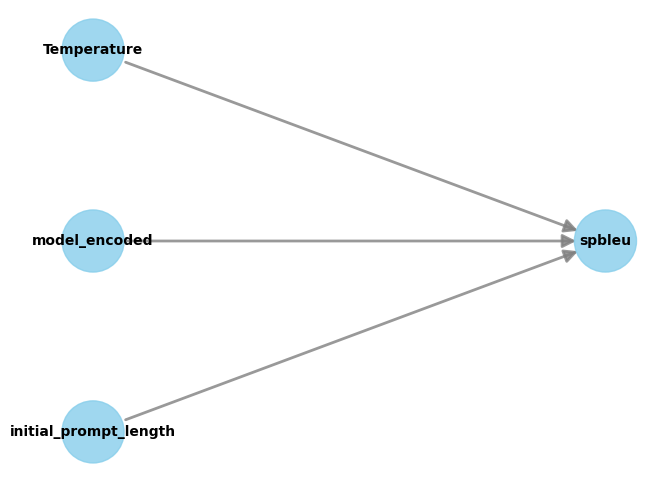

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                  
──────────────(E[spbleu])
d[Temperature]           
Estimand assumption 1, Unconfoundedness: If U→{Temperature} and U→spbleu then P(spbleu|Temperature,,U) = P(spbleu|Temperature,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [4]:
model = CausalModel(
    data=causal_dataset_df,
    treatment=["Temperature"],
    outcome=["spbleu"],
    effect_modifiers=["model_encoded", "initial_prompt_length"],
)
model.view_model()

identified_estimand = model.identify_effect()
print(identified_estimand)

model_y = LinearRegression(fit_intercept=True)
model_t = LinearRegression(fit_intercept=True)

result_df = pd.DataFrame()
model_list = causal_dataset_df["model_encoded"].unique().tolist()
for control_value in control_values:
    dml_estimate = model.estimate_effect(
        identified_estimand,
        method_name="backdoor.econml.dml.LinearDML",
        confidence_intervals=True,
        control_value=control_value,
        treatment_value=control_value + step,
        method_params={
            "init_params": {
                "model_y": model_y,
                "model_t": model_t,
            }
        },
        fit_estimator=True,
    )
    for model_encoded in model_list:
        dml_estimate = model.estimate_effect(
            identified_estimand,
            method_name="backdoor.econml.dml.LinearDML",
            target_units=causal_dataset_df[
                causal_dataset_df["model_encoded"] == model_encoded
            ],
            confidence_intervals=True,
            control_value=control_value,
            treatment_value=control_value + step,
            method_params={
                "init_params": {
                    "model_y": model_y,
                    "model_t": model_t,
                }
            },
            fit_estimator=False,
        )
        estimate_value = dml_estimate.cate_estimates[0]
        lower_bound = dml_estimate.get_confidence_intervals()[:, :, 0][0][0]
        upper_bound = dml_estimate.get_confidence_intervals()[:, :, 0][1][0]
        data = {
            "lower_bound": lower_bound,
            "upper_bound": upper_bound,
            "estimate_value": estimate_value,
            "control_value": control_value,
            "model_encoded": model_encoded,
        }
        data_df = pd.DataFrame(data)
        result_df = pd.concat([result_df, data_df], ignore_index=True)

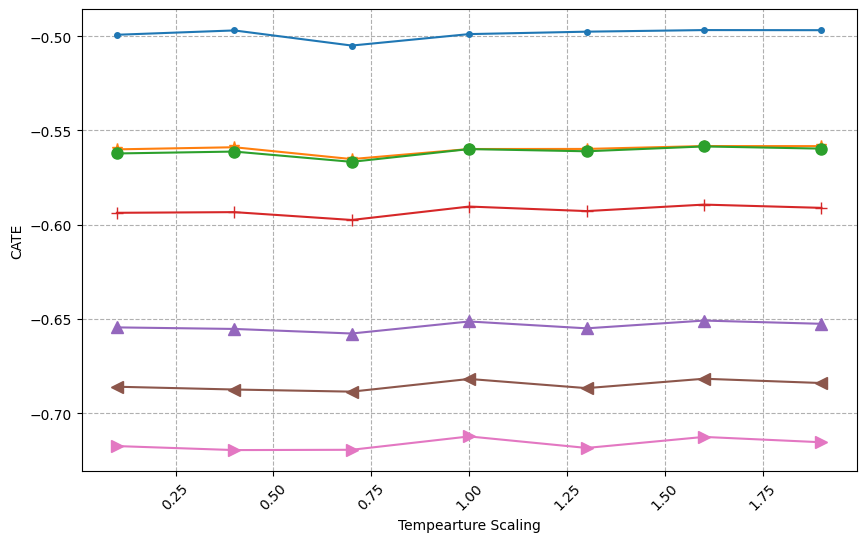

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

reversed_model_map = {value: key for key, value in model_map.items()}
result_df["control_value"] = result_df["control_value"].round(1)
result_df["model_name"] = result_df["model_encoded"].map(reversed_model_map)
grouped = result_df.groupby("model_name")

current_time = datetime.datetime.now()
current_time_str = current_time.strftime("%Y%m%d%H%M%S")
output_photo_name = f"MT_{current_time_str}.svg"
plt.figure(figsize=(10, 6))
i = 0
for name, group in grouped:
    plt.plot(
        group["control_value"],
        group["estimate_value"],
        label=name,
        color=color_map[name],
        marker=marker_map[name],
        markersize=8,
    )
    i += 1
    # plt.fill_between(group['control_value'], group['lower_bound'], group['upper_bound'], alpha=0.01)
plt.grid(
    linestyle="--",
)
plt.xticks(rotation=45)
# plt.legend()

plt.xlabel("Tempearture Scaling")
plt.ylabel("CATE")
plt.savefig(output_photo_path, format="svg", bbox_inches="tight")
# plt.title("Estimate Value vs Control Value for Different Model Encodings")
plt.show()